In [14]:
#Importing all needed librarys
import torch
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor, Lambda, Compose
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from pipetorch.train import *
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD
from tqdm import tqdm
from torch import nn, optim
import seaborn as sns
import torch.nn.functional as F

# importing the libraries
import pandas as pd
import numpy as np

# for creating validation set
from sklearn.model_selection import train_test_split


import torchvision
from torchvision.datasets import ImageFolder

In [15]:
#Checking wich GPU is beeing used

!nvidia-smi

Fri Dec 17 18:55:35 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.86       Driver Version: 470.86       CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:05:00.0 Off |                  N/A |
| 29%   36C    P2    63W / 250W |   9260MiB / 11019MiB |     14%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:09:00.0 Off |                  N/A |
| 29%   

In [16]:
#Load data
data_speaker1_dir = 'dialogue/Dataset/SameVoiceDetection/sr44khz/44khz50_10_speaker1.npy'
#data_speaker1_dir = 'dialogue/Leander/outputs/speaker1.npy'
data_speaker2_dir = 'dialogue/Dataset/SameVoiceDetection/sr44khz/44khz50_10_speaker2.npy'
#data_speaker2_dir = 'dialogue/Leander/outputs/speaker2.npy'
labels_dir = 'dialogue/Dataset/SameVoiceDetection/sr44khz/44khz50_10_labels.npy'
#labels_dir = 'dialogue/Leander/outputs/labels.npy'

data_speaker1 = np.load(data_speaker1_dir, allow_pickle = True)
data_speaker2 = np.load(data_speaker2_dir, allow_pickle = True)
#data_speaker1 = data_speaker1.reshape((len(data_speaker1),40,len(data_speaker1[0])//40))
#data_speaker2 = data_speaker2.reshape((len(data_speaker2),40,len(data_speaker2[0])//40))
labels = np.load(labels_dir, allow_pickle = True)

print(data_speaker1.shape, data_speaker2.shape)
print(labels)

(45000, 40, 44) (45000, 40, 44)
[ True False  True ... False  True False]


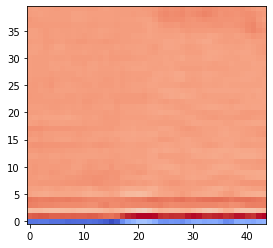

In [17]:
from matplotlib import cm
fig, ax = plt.subplots()
mfcc_data = data_speaker1[1]
cox = ax.imshow(mfcc_data, interpolation = 'nearest', cmap = cm.coolwarm, origin = 'lower')
plt.show()

In [18]:
#df_data.drop(['isSpeaking'],axis = 1)
X1_train, X1_val, y_train, y_val = train_test_split(data_speaker1, labels, test_size = 0.2, random_state = 23)
X1_train, X1_test, y_train, y_test = train_test_split(X1_train, y_train, test_size = 0.2, random_state = 23)

X2_train, X2_val, y_train, y_val = train_test_split(data_speaker2, labels, test_size = 0.2, random_state = 23)
X2_train, X2_test, y_train, y_test = train_test_split(X2_train, y_train, test_size = 0.2, random_state = 23)

print(type(X1_train))
#print(X_train)

<class 'numpy.ndarray'>


In [19]:
X1_train = torch.from_numpy(X1_train).float()

X2_train = torch.from_numpy(X2_train).float()

y_train = torch.from_numpy(y_train).float()

X1_val = torch.from_numpy(X1_val).float()

X2_val = torch.from_numpy(X2_val).float()

y_val = torch.from_numpy(y_val).float()

X1_test = torch.from_numpy(X1_test).float()

X2_test = torch.from_numpy(X2_test).float()

y_test = torch.from_numpy(y_test).float()

print(X2_train.shape, y_train.shape)

print(X2_train[0])


torch.Size([28800, 40, 44]) torch.Size([28800])
tensor([[-5.5899e+02, -5.6249e+02, -5.7094e+02,  ..., -6.3525e+02,
         -6.3875e+02, -6.4773e+02],
        [ 2.1026e+02,  2.0660e+02,  1.9210e+02,  ...,  1.3748e+02,
          1.3503e+02,  1.2722e+02],
        [ 3.6705e+01,  3.1515e+01,  1.8319e+01,  ...,  1.4886e+01,
          1.4073e+01,  1.3030e+01],
        ...,
        [-6.2101e+00, -6.4652e+00, -4.1809e+00,  ...,  5.0403e-01,
         -9.4124e-01, -4.2503e+00],
        [-6.5571e+00, -2.6972e+00, -2.8658e+00,  ...,  4.2310e+00,
          3.4736e+00, -9.1387e-01],
        [-1.8022e+00,  1.2926e-01, -5.4475e+00,  ...,  3.9230e+00,
          6.1181e+00,  3.3706e+00]])


In [20]:
class model(nn.Module):
    def __init__(self,n_features,kernel_size):
        super(model, self).__init__()
        self.conv1 = nn.Conv1d(n_features, 40, kernel_size=7, stride = 1, padding = 3, padding_mode= 'zeros') #40 input channels, 40 output channels
        self.conv2 = nn.Conv1d(40, 60, kernel_size=5, stride = 1, padding = 2, padding_mode= 'zeros') #40 input channels from previous Conv. layer, 80 out
        self.conv3 = nn.Conv1d(60, 70, kernel_size=3, stride = 1, padding = 1, padding_mode= 'zeros')
        self.conv4 = nn.Conv1d(70, 80, kernel_size=3, stride = 1, padding = 1, padding_mode= 'zeros')

        self.fc1 = nn.Linear(320, 200) #Fully-connected classifier layer 
        self.fc2 = nn.Linear(200, 100)
        self.fc3 = nn.Linear(100, 1) #Fully-connected classifier layer
    
    def forward_one_voice(self, x):
        x = F.relu(F.max_pool1d(self.conv1(x), 2))
        x = F.relu(F.max_pool1d(self.conv2(x), 2))
        x = F.relu(F.max_pool1d(self.conv3(x), 2))
        x = F.relu(F.max_pool1d(self.conv4(x), 2))
        
        x = x.reshape(len(x), -1)
        batch_size = len(x)
        
        return x
    
    def forward(self, x1, x2):
        x1 = self.forward_one_voice(x1)
        x2 = self.forward_one_voice(x2)
        x = torch.concat([x1, x2], axis = 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        
        return torch.sigmoid(x)
    
    def post_forward(self, y): 
        return torch.round(y)
    
CNN = model(X1_train.shape[1],kernel_size = 3)

In [21]:
weight = torch.FloatTensor([1])
criterion = nn.BCELoss()
optimizer = optim.Adam(CNN.parameters(), lr=0.00003)

In [22]:
train_ds = TensorDataset(X1_train, X2_train, y_train)
val_ds = TensorDataset(X1_val, X2_val, y_val)

In [23]:
batch_size = 32
train_dl = DataLoader(train_ds, batch_size= batch_size, num_workers = 4, pin_memory = True)
#val_dl = DataLoader(val_ds, batch_size= 32)

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# X1_train = X1_train.to(device)
# X2_train = X2_train.to(device)
# y_train = y_train.to(device)
X1_val = X1_val.to(device)
X2_val = X2_val.to(device)
y_val = y_val.to(device)

X1_test = X1_test.to(device)
X2_test = X2_test.to(device)
y_test = y_test.to(device)

CNN = CNN.to(device)
criterion = criterion.to(device)
print(device)

cuda


In [25]:
def calculate_accuracy(y_true, y_pred):
    return (y_true == y_pred).sum().float() / len(y_true)

In [26]:
def round_tensor(t, decimal_places=3):
    return round(t.item(), decimal_places)
    
Results = pd.DataFrame(columns = ['Epoch', 'Acc_train', 'Acc_val', 'val_loss', 'train_loss'])
    
for epoch in range(100):
    y_acc = torch.empty((batch_size),dtype= torch.int32, device = 'cuda')
    y_pred_acc = torch.empty((batch_size), device = 'cuda')
    for x1, x2, y in train_dl:
        x1, x2, y = x1.to(device), x2.to(device), y.to(device)
        optimizer.zero_grad()
        y_pred = CNN(x1, x2)
        y_pred = y_pred.squeeze()
        train_loss = criterion(y_pred, y)
        train_loss.backward()
        optimizer.step()
        y_acc = torch.concat([y, y_acc], axis = 0)
        y_pred_acc = torch.concat([y_pred, y_pred_acc], axis = 0)
    if epoch % 1 == 0:


        train_acc = calculate_accuracy(y_acc, CNN.post_forward(y_pred_acc))
    
        y_val_pred = CNN(X1_val, X2_val)
        y_val_pred = y_val_pred.squeeze()
        val_loss = criterion(y_val_pred, y_val)
    
        val_acc = calculate_accuracy(y_val, CNN.post_forward(y_val_pred))
    
        result = {'Epoch': epoch, 'Acc_train': round_tensor(train_acc), 'Acc_val': round_tensor(val_acc), 'val_loss': round_tensor(val_loss), 'train_loss': round_tensor(train_loss)}

        Results = Results.append(result, ignore_index=True)

        print(
f'''epoch {epoch}
Train set - loss: {round_tensor(train_loss)}, accuracy: {round_tensor(train_acc)}
val  set - loss: {round_tensor(val_loss)}, accuracy: {round_tensor(val_acc)}
''')

epoch 0
Train set - loss: 0.536, accuracy: 0.58
val  set - loss: 0.547, accuracy: 0.726

epoch 1
Train set - loss: 0.488, accuracy: 0.744
val  set - loss: 0.517, accuracy: 0.749

epoch 2
Train set - loss: 0.475, accuracy: 0.756
val  set - loss: 0.506, accuracy: 0.755

epoch 3
Train set - loss: 0.454, accuracy: 0.765
val  set - loss: 0.496, accuracy: 0.761

epoch 4
Train set - loss: 0.431, accuracy: 0.774
val  set - loss: 0.486, accuracy: 0.768

epoch 5
Train set - loss: 0.403, accuracy: 0.783
val  set - loss: 0.47, accuracy: 0.777

epoch 6
Train set - loss: 0.362, accuracy: 0.797
val  set - loss: 0.439, accuracy: 0.797

epoch 7
Train set - loss: 0.34, accuracy: 0.816
val  set - loss: 0.419, accuracy: 0.812

epoch 8
Train set - loss: 0.335, accuracy: 0.828
val  set - loss: 0.403, accuracy: 0.822

epoch 9
Train set - loss: 0.335, accuracy: 0.838
val  set - loss: 0.39, accuracy: 0.831

epoch 10
Train set - loss: 0.336, accuracy: 0.846
val  set - loss: 0.378, accuracy: 0.838

epoch 11
Trai

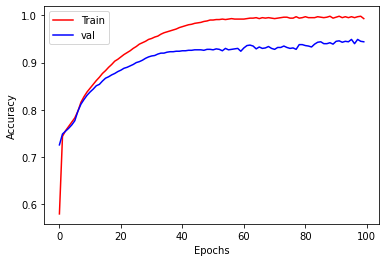

    Epoch  Acc_train  Acc_val  val_loss  train_loss
0     0.0      0.580    0.726     0.547       0.536
1     1.0      0.744    0.749     0.517       0.488
2     2.0      0.756    0.755     0.506       0.475
3     3.0      0.765    0.761     0.496       0.454
4     4.0      0.774    0.768     0.486       0.431
..    ...        ...      ...       ...         ...
95   95.0      0.997    0.949     0.247       0.001
96   96.0      0.995    0.940     0.311       0.052
97   97.0      0.997    0.949     0.260       0.000
98   98.0      0.998    0.945     0.302       0.001
99   99.0      0.993    0.944     0.259       0.004

[100 rows x 5 columns]


In [27]:
plt.plot(Results.Epoch,Results.Acc_train,'r',Results.Epoch,Results.Acc_val,'b')
plt.legend(['Train','val'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()
print(Results)

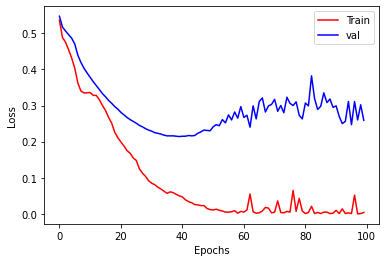

In [28]:
plt.plot(Results.Epoch,Results.train_loss,'r',Results.Epoch,Results.val_loss,'b')
plt.legend(['Train','val'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [29]:
classes = ['Different Voice', 'Same Voice']
y_pred = CNN(X1_val, X2_val)
y_pred = y_pred.ge(.5).view(-1).cpu()
y_val = y_val.cpu()
print(classification_report(y_val, y_pred, target_names=classes))

                 precision    recall  f1-score   support

Different Voice       0.94      0.95      0.95      4523
     Same Voice       0.95      0.94      0.94      4477

       accuracy                           0.94      9000
      macro avg       0.94      0.94      0.94      9000
   weighted avg       0.94      0.94      0.94      9000



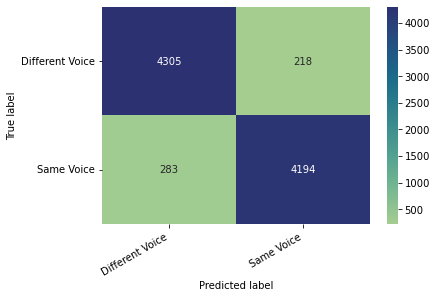

In [30]:
cm = confusion_matrix(y_val, y_pred)
df_cm = pd.DataFrame(cm, index=classes, columns=classes)
hmap = sns.heatmap(df_cm, annot=True, fmt="d", cmap= 'crest')
hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label');

In [31]:
y_pred = CNN(X1_test, X2_test)
y_pred = y_pred.ge(.5).view(-1).cpu()
y_test = y_test.cpu()
print(classification_report(y_test, y_pred, target_names=classes))

                 precision    recall  f1-score   support

Different Voice       0.93      0.95      0.94      3510
     Same Voice       0.95      0.93      0.94      3690

       accuracy                           0.94      7200
      macro avg       0.94      0.94      0.94      7200
   weighted avg       0.94      0.94      0.94      7200



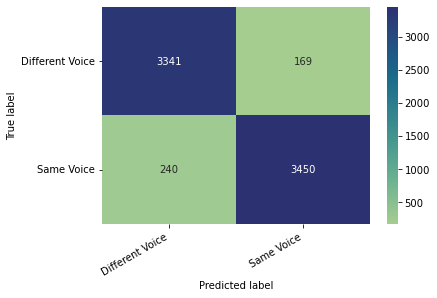

In [32]:
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=classes, columns=classes)
hmap = sns.heatmap(df_cm, annot=True, fmt="d", cmap= 'crest')
hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label');

In [33]:
#Shutting down the notebook

%%javascript
Jupyter.notebook.session.delete();

UsageError: Line magic function `%%javascript` not found.
